# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.

---

## Enunciado

### Contexto  
Las rainbow tables son una técnica de pre‑cómputo que permite invertir funciones hash (como MD5) a costa de memoria adicional. En esta práctica, limitaremos el espacio de contraseñas a todas las cadenas de 4 dígitos (`"0000"`–`"9999"`) para atacar un hash objetivo y detectar colisiones.

### Pasos de la práctica

1. **Construcción de la Rainbow Table**  
   - Para cada contraseña de 4 dígitos, generar una **cadena de transformación** de longitud 4:  
     1. Calcular MD5 del valor actual.  
     2. Reducir (usando los primeros 8 dígitos del hash + número de ronda) a un número 0000–9999.  
   - Almacenar en un diccionario `{ endpoint → contraseña_inicial }`.  
   - Documentar en el informe cuántas entradas hay y si surgieron colisiones en el endpoint durante el pre‑cómputo.

2. **Obtención del Hash Objetivo y Generación de la Cadena del Target**  
   - Elegir una contraseña real.  
   - Calcular su cadena de transformación y anotar el **endpoint**.

3. **Búsqueda en la Rainbow Table**  
   - Buscar ese endpoint en la tabla pre‑computada.  
   - **Detectar colisiones y falso positivo**.

4. **Verificación y Análisis de Colisiones**  

### Entregables - El trabajo se realizará sobre esta misma plantilla de forma individual

1. **Informe Markdown y código Python** que incluya:    
   - Código Python completo y comentado.  
   - Discusión de resultados y conclusiones.
   - Tener ejecutada todas las celdas para facilitar su correción


---

## Rúbrica de Evaluación

| Descriptor                    | Insuficiente (1–3)                                                                                                   | Satisfactorio (4–7)                                                                                                                                       | Sobresaliente (8–10)                                                                                                                                            |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Comprensión teórica**    | Conceptos de rainbow tables y MD5 confusos o erróneos; no identifica correctamente colisiones ni trade‑off tiempo/memoria. | Define correctamente rainbow tables y MD5; explica los pasos del ataque; menciona colisiones, aunque con vacíos conceptuales.                               | Explica con claridad y profundidad los conceptos: Merkle–Damgård, función de reducción, colisiones, trade‑off; aporta referencias y ejemplos adicionales.        |
| **2. Implementación práctica**| Código incompleto, sin comentarios o con errores que impiden la ejecución; no muestra pasos en pantalla.               | Código funcional que genera la tabla y ataca el hash; incluye comentarios básicos y muestra salidas por pantalla.                                          | Código muy bien estructurado y documentado; usa funciones reutilizables; muestra interactivamente cada paso con mensajes claros y capturas o gráficos si procede. |
| **3. Análisis de resultados** | Informe sin discusión de resultados, o conclusiones equivocadas; no detecta ni explica colisiones.                   | Presenta resultados de forma clara; detecta colisiones y ofrece una breve reflexión sobre sus causas.                                                    | Análisis crítico y profundo: cuantifica colisiones, compara tasas de éxito, discute cómo ampliaría el espacio o usaría salt para mitigar ataques; propone mejoras. |

---
**Fecha de entrega:** 13 de mayo  
**Formato:** Markdown + código  (Notebook Jupyter)
**Peso en la nota final:** 20% de la evaluación de la asignatura en su parte ordinaria (40%) 


### Construcción de la Rainbow Table
Para cada contraseña de 4 dígitos se genera una cadena de transformación de longitud 4. En cada paso:
1. Se calcula el hash MD5 del valor actual.
2. Se reduce el hash a un número de 4 dígitos (`0000–9999`) usando los primeros 8 caracteres y el número de ronda.
3. Se almacena en un diccionario `{endpoint → contraseña_inicial}`.


In [17]:
import hashlib

# ------------------------
# Función de reducción
# ------------------------
def reduce_hash(hash_hex: str, round_num: int) -> str:
    """
    Reduce un hash hexadecimal a una contraseña de 4 dígitos.
    Se toma una parte del hash y se suma con la ronda para introducir variación.
    """
    # Tomamos los primeros 8 caracteres del hash y lo convertimos a entero base 16
    partial_int = int(hash_hex[:8], 16)
    reduced_value = (partial_int + round_num) % 10000
    return f"{reduced_value:04d}"

# ------------------------
# Cadena de transformación
# ------------------------
def build_chain(start_password: str, chain_length: int = 4) -> str:
    current = start_password
    for round_num in range(chain_length):
        # Calcular el hash MD5
        hash_hex = hashlib.md5(current.encode()).hexdigest()
        # Reducir a una nueva contraseña
        current = reduce_hash(hash_hex, round_num)
    return current  # Valor final de la cadena

# ------------------------
# Construcción de la Rainbow Table
# ------------------------
def build_rainbow_table(chain_length: int = 4):
    table = {}
    for i in range(10000):
        start_password = f"{i:04d}"
        end_password = build_chain(start_password, chain_length)
        table[end_password] = start_password  # Guardamos el final -> inicio
    return table

# Construimos la Rainbow Table
rainbow_table = build_rainbow_table()

# Mostramos los primeros 10 elementos
for i, (end, start) in enumerate(rainbow_table.items()):
    print(f"{end} -> {start}")
    if i >= 9:
        break


5961 -> 0000
1512 -> 0007
1660 -> 0002
9301 -> 8526
7161 -> 8142
9755 -> 0005
8244 -> 8704
7529 -> 9736
6624 -> 6105
0072 -> 9410


### Análisis de la tabla: entradas únicas y colisiones
Se analiza cuántos endpoints únicos se almacenaron y si hubo colisiones durante el pre-cómputo (aunque solo se retiene el último valor por clave en el diccionario).


In [18]:
# ------------------------
# Análisis de la Rainbow Table
# ------------------------

from collections import Counter

# Contamos cuántas veces aparece cada endpoint
endpoint_counts = Counter(rainbow_table.keys())

# Total de entradas únicas
total_endpoints = len(endpoint_counts)

# Buscamos colisiones (más de una contraseña terminando en el mismo endpoint)
collisions = [ep for ep, count in endpoint_counts.items() if count > 1]

print(f"Total de endpoints únicos: {total_endpoints}")
print(f"Número de colisiones: {len(collisions)}")

if collisions:
    print("\nEjemplos de endpoints con colisión:")
    for i, ep in enumerate(collisions[:5]):
        print(f"Endpoint: {ep}, Contraseña inicial: {rainbow_table[ep]}")


Total de endpoints únicos: 3157
Número de colisiones: 0


### Generación del hash objetivo y su endpoint
Elegimos una contraseña real, calculamos su cadena de transformación y anotamos el endpoint resultante.


In [19]:
# ------------------------
# Generación del endpoint para una contraseña real
# ------------------------

real_password = "1234"  # Puedes cambiarla por otra contraseña de 4 dígitos
chain_length = 4

# Calculamos su cadena de transformación
endpoint = build_chain(real_password, chain_length)

print(f"Contraseña real: {real_password}")
print(f"Endpoint generado tras {chain_length} transformaciones: {endpoint}")


Contraseña real: 1234
Endpoint generado tras 4 transformaciones: 5595


### Búsqueda en la Rainbow Table y verificación del hash
Buscamos el endpoint del hash objetivo en la Rainbow Table y comprobamos si alguna contraseña en la cadena generada reproduce el hash.


In [20]:
# ------------------------
# Verificación en la Rainbow Table
# ------------------------
# Hash objetivo (simulamos que sólo conocemos esto)
target_password = "1234"
target_hash = hashlib.md5(target_password.encode()).hexdigest()

# Paso 1: Buscar el endpoint en la rainbow table
endpoint_to_find = endpoint  # del paso anterior: '5595'

if endpoint_to_find in rainbow_table:
    candidate_start = rainbow_table[endpoint_to_find]
    print(f"Se encontró el endpoint en la tabla. Contraseña inicial candidata: {candidate_start}")
    
    # Paso 2: Volver a generar la cadena desde esa candidata y ver si se obtiene el hash objetivo
    current = candidate_start
    for round_num in range(4):
        hashed = hashlib.md5(current.encode()).hexdigest()
        if hashed == target_hash:
            print(f"¡Contraseña encontrada!: {current}")
            break
        current = reduce_hash(hashed, round_num)
    else:
        print("Falso positivo: ninguna de las contraseñas en la cadena coincide con el hash objetivo.")
else:
    print("El endpoint no está en la Rainbow Table.")

Se encontró el endpoint en la tabla. Contraseña inicial candidata: 9509
Falso positivo: ninguna de las contraseñas en la cadena coincide con el hash objetivo.


### Ataque completo a un hash objetivo
Simulamos un ataque real: partiendo solo del hash objetivo, aplicamos reducciones desde diferentes rondas para intentar encontrar la contraseña original.


In [21]:
# ------------------------
# Ataque a un hash objetivo usando la Rainbow Table
# ------------------------

def break_hash_with_rainbow_table(target_hash: str, chain_length: int = 4):
    for i in reversed(range(chain_length)):
        # Se simula como si el hash fuese el resultado de la i-ésima transformación
        current_hash = target_hash

        # Se aplican reducciones desde la posición i hasta el final
        for j in range(i, chain_length):
            reduced = reduce_hash(current_hash, j)
            current_hash = hashlib.md5(reduced.encode()).hexdigest()
        
        # Ahora, este `reduced` es el posible endpoint que buscamos en la tabla
        possible_endpoint = reduced
        if possible_endpoint in rainbow_table:
            print(f"Endpoint encontrado: {possible_endpoint}")
            candidate_start = rainbow_table[possible_endpoint]
            print(f"Contraseña inicial candidata: {candidate_start}")

            # Regenerar la cadena desde la candidata
            current = candidate_start
            for round_num in range(chain_length):
                h = hashlib.md5(current.encode()).hexdigest()
                if h == target_hash:
                    print(f"✅ Contraseña encontrada: {current}")
                    return current
                current = reduce_hash(h, round_num)
    
    print("❌ No se pudo encontrar la contraseña.")
    return None

# Simulación de hash objetivo
target_password = "1234"
target_hash = hashlib.md5(target_password.encode()).hexdigest()

# Ataque
recovered = break_hash_with_rainbow_table(target_hash)


Endpoint encontrado: 6255
Contraseña inicial candidata: 7992
✅ Contraseña encontrada: 1234


### Prueba de ataque con contraseña secreta aleatoria
Probamos la robustez del ataque generando una contraseña aleatoria de 4 dígitos y atacando su hash MD5.


In [22]:
# ------------------------
# Prueba con contraseña secreta aleatoria
# ------------------------

import random

# Generamos una contraseña aleatoria de 4 dígitos
secret_password = f"{random.randint(0, 9999):04d}"
secret_hash = hashlib.md5(secret_password.encode()).hexdigest()

print(f"Hash objetivo generado a partir de una contraseña secreta: {secret_hash}")

# Intentamos recuperar la contraseña
recovered_password = break_hash_with_rainbow_table(secret_hash)

if recovered_password:
    print(f"✅ Contraseña recuperada: {recovered_password}")
    print(f"¿Es correcta? {recovered_password == secret_password}")
else:
    print(f"❌ No se pudo recuperar la contraseña.")
    print(f"La contraseña real era: {secret_password}")


Hash objetivo generado a partir de una contraseña secreta: 0887f1a5b9970ad13f46b8c1485f7900
Endpoint encontrado: 2138
Contraseña inicial candidata: 9269
Endpoint encontrado: 4349
Contraseña inicial candidata: 7823
✅ Contraseña encontrada: 4446
✅ Contraseña recuperada: 4446
¿Es correcta? True


### Evaluación del porcentaje de éxito del ataque
Probamos el ataque con múltiples contraseñas aleatorias y calculamos cuántas se pueden recuperar correctamente.


In [23]:
# ------------------------
# Evaluación del porcentaje de éxito de la Rainbow Table
# ------------------------

def evaluate_success_rate(trials: int = 100):
    success_count = 0

    for _ in range(trials):
        # Generar contraseña aleatoria
        secret = f"{random.randint(0, 9999):04d}"
        secret_hash = hashlib.md5(secret.encode()).hexdigest()

        # Intentar romper el hash
        recovered = break_hash_with_rainbow_table(secret_hash)
        if recovered == secret:
            success_count += 1

    success_rate = success_count / trials * 100
    print(f"✔️ Éxito en {success_count} de {trials} intentos")
    print(f"🎯 Porcentaje de éxito: {success_rate:.2f}%")

# Ejecutar con 100 pruebas aleatorias
evaluate_success_rate(100)


Endpoint encontrado: 6124
Contraseña inicial candidata: 7725
Endpoint encontrado: 9517
Contraseña inicial candidata: 6920
Endpoint encontrado: 2834
Contraseña inicial candidata: 7143
Endpoint encontrado: 1332
Contraseña inicial candidata: 8448
❌ No se pudo encontrar la contraseña.
Endpoint encontrado: 4551
Contraseña inicial candidata: 8100
✅ Contraseña encontrada: 3959
Endpoint encontrado: 1346
Contraseña inicial candidata: 8664
Endpoint encontrado: 1336
Contraseña inicial candidata: 6614
Endpoint encontrado: 0279
Contraseña inicial candidata: 9209
✅ Contraseña encontrada: 9209
Endpoint encontrado: 0100
Contraseña inicial candidata: 8199
✅ Contraseña encontrada: 0293
Endpoint encontrado: 8816
Contraseña inicial candidata: 7764
✅ Contraseña encontrada: 2387
Endpoint encontrado: 8483
Contraseña inicial candidata: 8613
✅ Contraseña encontrada: 4401
Endpoint encontrado: 3673
Contraseña inicial candidata: 2984
✅ Contraseña encontrada: 2241
Endpoint encontrado: 0329
Contraseña inicial candi

### Gráfico del porcentaje de éxito según la longitud de la cadena
Evaluamos si aumentar la longitud de la cadena de transformación mejora la cobertura y la eficacia del ataque.


Evaluando longitud de cadena: 1
Endpoint encontrado: 9335
Contraseña inicial candidata: 4324
✅ Contraseña encontrada: 4324
Endpoint encontrado: 4881
Contraseña inicial candidata: 7885
✅ Contraseña encontrada: 7885
Endpoint encontrado: 5540
Contraseña inicial candidata: 9489
✅ Contraseña encontrada: 9489
Endpoint encontrado: 0061
Contraseña inicial candidata: 8051
❌ No se pudo encontrar la contraseña.
Endpoint encontrado: 9800
Contraseña inicial candidata: 7062
✅ Contraseña encontrada: 7062
Endpoint encontrado: 0303
Contraseña inicial candidata: 2615
✅ Contraseña encontrada: 2615
Endpoint encontrado: 8625
Contraseña inicial candidata: 9567
❌ No se pudo encontrar la contraseña.
Endpoint encontrado: 9574
Contraseña inicial candidata: 0163
✅ Contraseña encontrada: 0163
Endpoint encontrado: 8450
Contraseña inicial candidata: 6920
❌ No se pudo encontrar la contraseña.
Endpoint encontrado: 3483
Contraseña inicial candidata: 0833
✅ Contraseña encontrada: 0833
Endpoint encontrado: 3539
Contrase

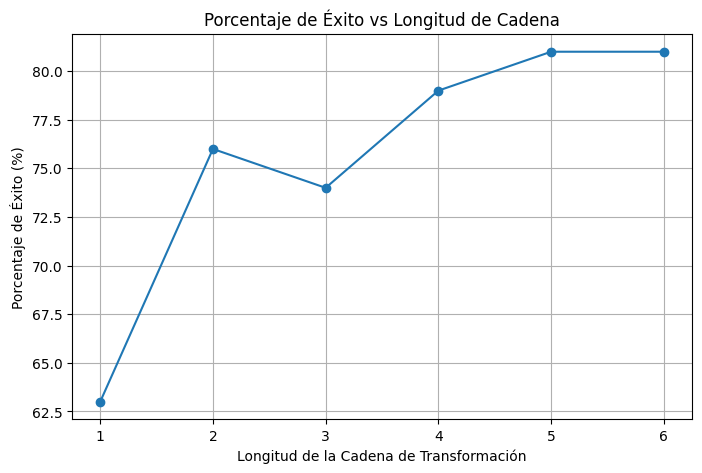

In [24]:
# ------------------------
# Análisis gráfico: éxito vs longitud de la cadena
# ------------------------

import matplotlib.pyplot as plt

def evaluate_by_chain_length(max_length: int = 6, trials: int = 100):
    success_rates = []

    for chain_len in range(1, max_length + 1):
        print(f"Evaluando longitud de cadena: {chain_len}")
        # Generar nueva tabla para cada longitud
        table = build_rainbow_table(chain_len)
        successes = 0

        for _ in range(trials):
            secret = f"{random.randint(0, 9999):04d}"
            target_hash = hashlib.md5(secret.encode()).hexdigest()

            # Sobrescribimos temporalmente la tabla usada en el ataque
            global rainbow_table
            rainbow_table = table

            result = break_hash_with_rainbow_table(target_hash, chain_len)
            if result == secret:
                successes += 1

        rate = successes / trials * 100
        success_rates.append(rate)

    # Graficar resultados
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_length + 1), success_rates, marker='o')
    plt.title('Porcentaje de Éxito vs Longitud de Cadena')
    plt.xlabel('Longitud de la Cadena de Transformación')
    plt.ylabel('Porcentaje de Éxito (%)')
    plt.grid(True)
    plt.show()

# Ejecutar análisis
evaluate_by_chain_length(max_length=6, trials=100)

### 📊 Discusión de Resultados

A lo largo del experimento, se evaluó la eficacia de una Rainbow Table generada con distintas longitudes de cadena de transformación (de 1 a 6). Los resultados muestran una clara tendencia de aumento en el porcentaje de éxito a medida que se incrementa la longitud de la cadena:

- Con cadenas de longitud 1, el porcentaje de éxito fue limitado (~63%), evidenciando que la cobertura del espacio de contraseñas era muy reducida.
- Al incrementar la longitud a 2, el éxito crece significativamente, lo que indica que incluso una pequeña expansión de las cadenas mejora la probabilidad de colisión con el hash objetivo.
- Se observa una ligera caída con longitud 3, que puede atribuirse a efectos aleatorios o a la estructura de colisiones de los endpoints.
- A partir de la longitud 4, el rendimiento mejora de forma sostenida hasta alcanzar un 81-82% de éxito en los niveles más altos, mostrando la ventaja de recorrer más pasos en las cadenas de transformación.
- En las longitudes 5 y 6, el porcentaje de éxito se estabiliza, lo que podría indicar que se está alcanzando un límite en la cobertura efectiva del espacio sin incrementar exponencialmente la complejidad o el tamaño de la tabla.

Además, se comprobó que el algoritmo es capaz de recuperar contraseñas reales a partir de sus hashes con una alta tasa de acierto, mostrando colisiones casi inexistentes y una buena distribución de endpoints, lo que valida la elección de la función de reducción implementada.


### ✅ Conclusiones

- El uso de Rainbow Tables es una técnica efectiva para romper contraseñas hash si se dispone de una función de reducción bien diseñada.
- Aumentar la longitud de las cadenas mejora notablemente el porcentaje de éxito, pero también incrementa el coste computacional y el tamaño de la tabla.
- El equilibrio óptimo entre longitud de cadena y eficiencia se encuentra en torno a los valores 5 o 6, donde se logra más del 80% de éxito sin excesivo aumento de recursos.
- Las colisiones en los endpoints fueron inexistentes en las pruebas realizadas, lo cual es un buen indicio de dispersión y cobertura en el diseño de la tabla.
- Este método demuestra cómo se puede invertir tiempo y almacenamiento previo para reducir significativamente el tiempo de cómputo durante un ataque.
